In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')  # Thème sombre
import statsmodels.api as sm

In [2]:
# Charge les données ETHUSDT
df = pd.read_parquet('ETHUSDT.parquet')
# Calcul des rendements ETH USDT
market_returns = df.close.pct_change().dropna()

<Axes: xlabel='close_time'>

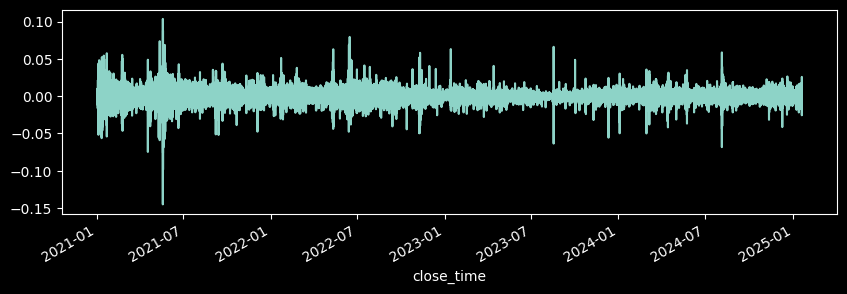

In [3]:
market_returns.plot(figsize=(10,3))

---
### Calcul de l'alpha

Calcul :  (CAPM simplifié)
>Rendements_Stratégie =  β × Rendement_marché + α

- Beta (β): Sensibilité de la stratégie au marché
- Alpha (α): La “surperformance pure”  

> Beta faible, alpha élevé = Le Saint Graal 

---
Nos Exemples

| Stratégie | Alpha (α) | Beta (β) |
|-----------|-----------|----------|
| HOLD      |    0      |    1     |
| Levier2   |    0      |    2     |
| Alpha     |   0.05    |    1     |

In [4]:
# Création des stratégies
df = pd.DataFrame(index=market_returns.index)
df["market"] = market_returns
df["HOLD"] = market_returns
df["Levier2"] = market_returns * 2
df["Alpha"] = market_returns + 0.05  # triche : alpha ajouté à chaque point de facon constante

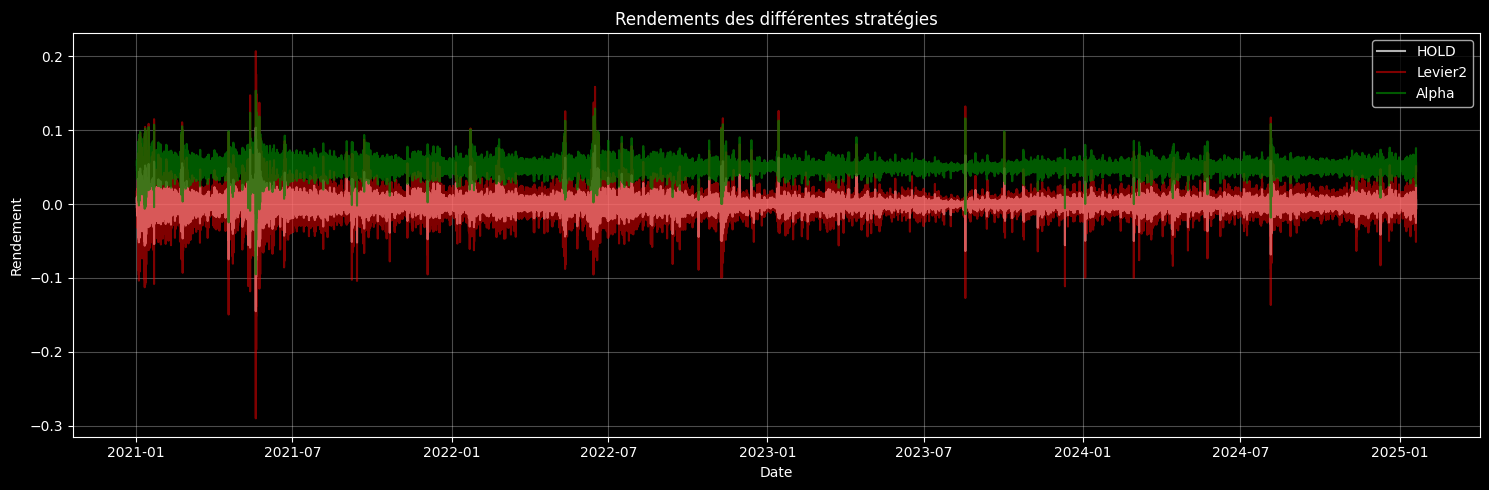

In [5]:
# Plot des rendements
plt.figure(figsize=(15, 5))
plt.plot(df.index, df["HOLD"], label="HOLD", alpha=0.7, color='white')
plt.plot(df.index, df["Levier2"], label="Levier2", alpha=0.5, color='red') 
plt.plot(df.index, df["Alpha"], label="Alpha", alpha=0.7, color='green')
plt.title("Rendements des différentes stratégies")
plt.xlabel("Date")
plt.ylabel("Rendement")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [6]:
# Fonction pour calculer alpha et beta (regression linéaire : rendements du marché VS rendements de la stratégie)
def compute_alpha_beta(strategy_returns, market_returns) -> dict:
    """
    Calcule l'alpha et le beta d'une stratégie par régression linéaire
    
    Parameters:
    strategy_returns : Series - Rendements de la stratégie
    market_returns : Series - Rendements du marché
    
    Returns:
    params : dict - Paramètres de la régression (alpha=const, beta=market)
    model : regression model - Modèle de régression
    """
    import statsmodels.api as sm
    import pandas as pd
    
    # Préparer les données pour la régression
    # Y = alpha + beta * X + epsilon
    # strategy_returns = alpha + beta * market_returns + epsilon
    
    X = market_returns.dropna()
    Y = strategy_returns.dropna()
    
    # S'assurer que les indices correspondent
    common_index = X.index.intersection(Y.index)
    X = X.loc[common_index]
    Y = Y.loc[common_index]
    
    # Ajouter une constante pour l'alpha (intercept)
    X_with_const = sm.add_constant(X)
    
    # Régression linéaire
    model = sm.OLS(Y, X_with_const).fit()
    
    # Extraire les paramètres
    params = {
        'const': model.params['const'],  # Alpha
        'market': model.params[market_returns.name]  # Beta
    }
    
    return params, model

In [7]:
# Calculer les alpha/beta pour toutes les stratégies
results = {}
for name in ["HOLD", "Levier2", "Alpha"]:
    params, model = compute_alpha_beta(df[name], df["market"])
    print(f"{name} : alpha = {params['const']:.2f}, beta = {params['market']:.2f}")
    # sauvegarde des résultats pour affichage
    results[name] = {"alpha": params["const"], "beta": params["market"], "model": model}

HOLD : alpha = 0.00, beta = 1.00
Levier2 : alpha = 0.00, beta = 2.00
Alpha : alpha = 0.05, beta = 1.00


---
Affichage Alpha et Beta

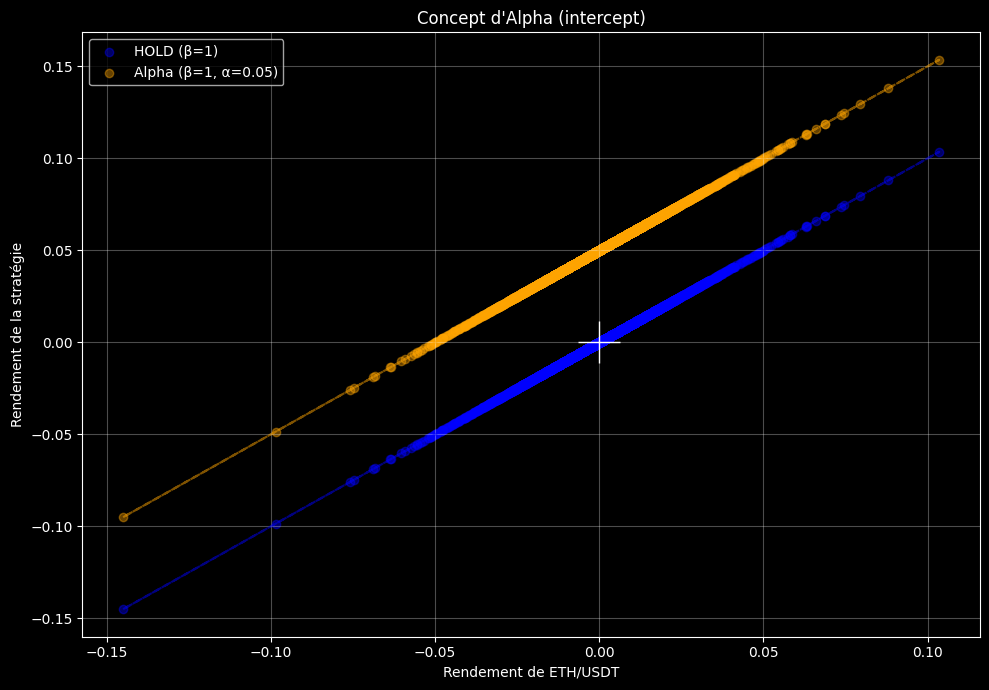

In [8]:
# Alpha plot
plt.figure(figsize=(10, 7))
plt.scatter(df["market"], df["HOLD"], alpha=0.4, label="HOLD (β=1)", color="blue")
plt.scatter(df["market"], df["Alpha"], alpha=0.4, label="Alpha (β=1, α=0.05)", color="orange")
X = sm.add_constant(df["market"])
plt.plot(df["market"], results["HOLD"]["model"].predict(X), linestyle='--', color="blue", alpha=0.5)
plt.plot(df["market"], results["Alpha"]["model"].predict(X), linestyle='--', color="orange", alpha=0.5)
# Add marker at origin (0,0)
plt.plot(0, 0, marker='+', markersize=30, color="white")
plt.title("Concept d'Alpha (intercept)")
plt.xlabel("Rendement de ETH/USDT")
plt.ylabel("Rendement de la stratégie")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
Beta (β)

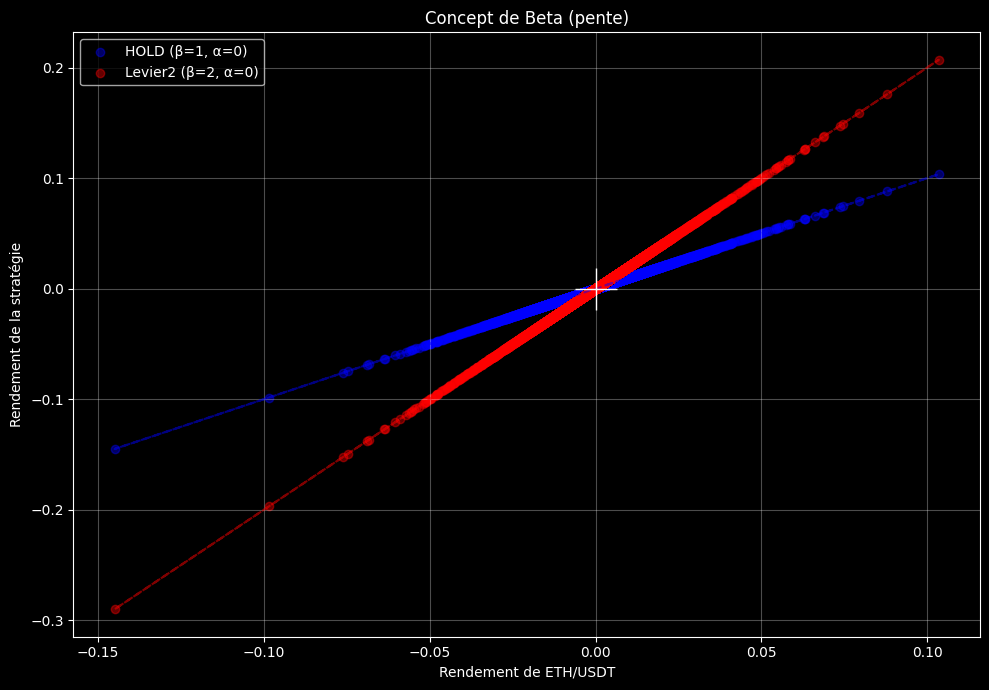

In [9]:
# Beta plot
plt.figure(figsize=(10, 7))
plt.scatter(df["market"], df["HOLD"], alpha=0.4, label="HOLD (β=1, α=0)", color="blue")
plt.scatter(df["market"], df["Levier2"], alpha=0.4, label="Levier2 (β=2, α=0)", color="red")
X = sm.add_constant(df["market"])
plt.plot(df["market"], results["HOLD"]["model"].predict(X), linestyle='--', color="blue", alpha=0.5)
plt.plot(df["market"], results["Levier2"]["model"].predict(X), linestyle='--', color="red", alpha=0.5)
plt.plot(0, 0, '+', markersize=30, color="white")
plt.title("Concept de Beta (pente)")
plt.xlabel("Rendement de ETH/USDT") 
plt.ylabel("Rendement de la stratégie")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

--- 
Point de Neutralisation d'Alpha

In [10]:
# Exemple de stratégie ultra sensible au marché
alpha_value = 0.05
beta_value = 5


Stratégie alphaB : Alpha = 0.05, Beta = 5
Point d'annulation : -0.0100 = -1.00%

Explication :
- Quand le marché baisse de 1.00%, l'alpha est complètement annulé
- Rendement de la stratégie = 0.05 + 5 × (-0.0100) = 0
- Pour des baisses > 1.00%, la stratégie sous-performe un portefeuille sans alpha


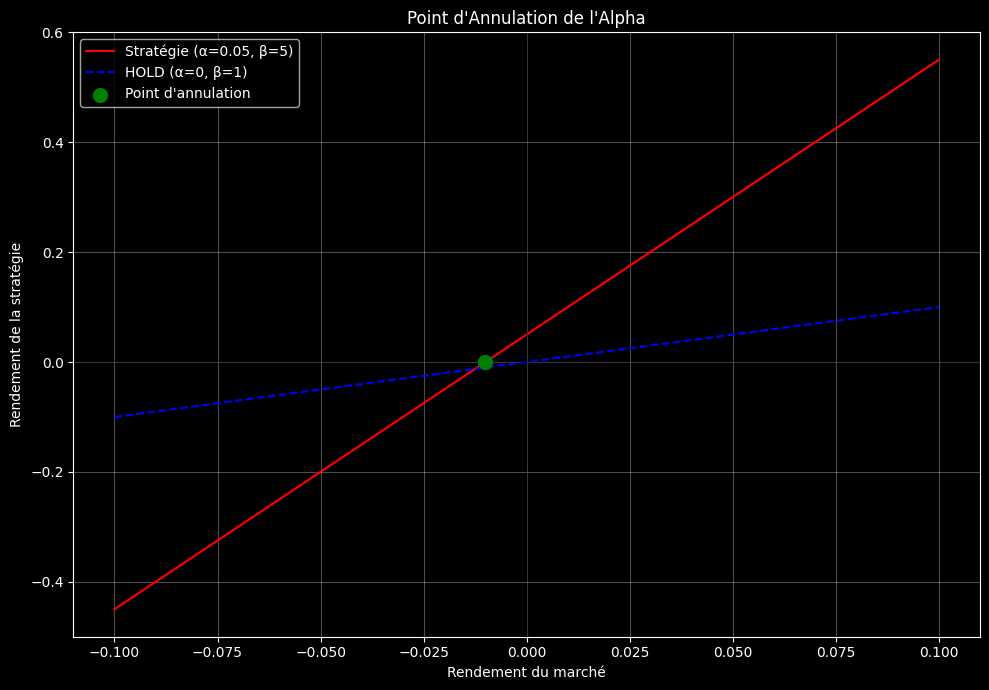

In [11]:
# Le point d'annulation est quand : alpha + beta * R_market = 0
# Donc : R_market = -alpha / beta
neutralization_point = -alpha_value / beta_value

print(f"\nStratégie alphaB : Alpha = {alpha_value}, Beta = {beta_value}")
print(f"Point d'annulation : {neutralization_point:.4f} = {neutralization_point*100:.2f}%")
print(f"\nExplication :")
print(f"- Quand le marché baisse de {abs(neutralization_point)*100:.2f}%, l'alpha est complètement annulé")
print(f"- Rendement de la stratégie = {alpha_value} + {beta_value} × ({neutralization_point:.4f}) = 0")
print(f"- Pour des baisses > {abs(neutralization_point)*100:.2f}%, la stratégie sous-performe un portefeuille sans alpha")

# Plot pour visualiser le point d'annulation
plt.figure(figsize=(10, 7))

# Créer une série de rendements du marché
market_returns = np.linspace(-0.1, 0.1, 100)
X = sm.add_constant(market_returns)

# Calculer les rendements de la stratégie
strategy_returns = alpha_value + beta_value * market_returns

# Tracer les lignes
plt.plot(market_returns, strategy_returns, label=f'Stratégie (α={alpha_value}, β={beta_value})', color='red')
plt.plot(market_returns, market_returns, label='HOLD (α=0, β=1)', color='blue', linestyle='--')

# Marquer le point d'annulation
plt.scatter([neutralization_point], [0], color='green', s=100, zorder=5, label="Point d'annulation")

plt.title("Point d'Annulation de l'Alpha")
plt.xlabel("Rendement du marché")
plt.ylabel("Rendement de la stratégie")
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()